In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn

data = pd.read_csv('2010-2017.csv')

data = data[['Date', 'Average Cost']]
data


data['Average Cost'] = data['Average Cost'].apply(lambda x: min(x, 100))


In [56]:
device = torch.device("cpu")
device

device(type='cpu')

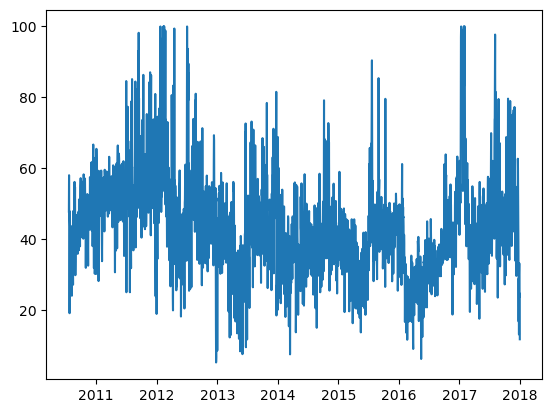

In [57]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Average Cost'])

In [58]:
from copy import deepcopy as dc

df = dc(data)
lookback = 15
df.set_index('Date', inplace=True)

for i in range(1, lookback+1):
    df[f'Average Cost (t-{i})'] = df['Average Cost'].shift(i)

df = df.iloc[15:]
df


,Average Cost,Average Cost (t-1),Average Cost (t-2),Average Cost (t-3),Average Cost (t-4),Average Cost (t-5),Average Cost (t-6),Average Cost (t-7),Average Cost (t-8),Average Cost (t-9),Average Cost (t-10),Average Cost (t-11),Average Cost (t-12),Average Cost (t-13),Average Cost (t-14),Average Cost (t-15)
Date,,,,,,,,,,,,,,,,
2010-08-05,39.80,41.03,41.32,43.67,28.92,38.43,42.24,43.87,43.73,47.85,38.12,19.15,43.59,46.15,58.06,47.80
2010-08-06,38.54,39.80,41.03,41.32,43.67,28.92,38.43,42.24,43.87,43.73,47.85,38.12,19.15,43.59,46.15,58.06
2010-08-07,35.11,38.54,39.80,41.03,41.32,43.67,28.92,38.43,42.24,43.87,43.73,47.85,38.12,19.15,43.59,46.15
2010-08-08,24.08,35.11,38.54,39.80,41.03,41.32,43.67,28.92,38.43,42.24,43.87,43.73,47.85,38.12,19.15,43.59
2010-08-09,38.74,24.08,35.11,38.54,39.80,41.03,41.32,43.67,28.92,38.43,42.24,43.87,43.73,47.85,38.12,19.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,30.21,13.16,28.97,16.80,36.42,40.89,51.45,59.94,62.71,48.88,31.02,35.84,48.93,40.31,50.46,39.02
2017-12-28,33.22,30.21,13.16,28.97,16.80,36.42,40.89,51.45,59.94,62.71,48.88,31.02,35.84,48.93,40.31,50.46
2017-12-29,23.76,33.22,30.21,13.16,28.97,16.80,36.42,40.89,51.45,59.94,62.71,48.88,31.02,35.84,48.93,40.31


In [59]:
np_df = df.to_numpy()

In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
np_df = scaler.fit_transform(np_df)

In [61]:
X = np_df[:, 1:]
y = np_df[:, 0]

In [62]:
X = dc(np.flip(X, axis=1))

In [63]:
spl_index = int(2706 * 0.9) 


# 2721 till 31 Dec 2017

X_train = X[:spl_index]
X_test = X[spl_index:2706]

y_train = y[:spl_index]
y_test = y[spl_index:2706]

X_train = X_train.reshape((-1,lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()


In [64]:
from torch.utils.data import Dataset

class ElectricityDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]
    
train_dataset = ElectricityDataset(X_train, y_train)
test_dataset = ElectricityDataset(X_test, y_test)

In [65]:
from torch.utils.data import DataLoader

batch_size = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


In [66]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 256, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [67]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device).float(), batch[1].to(device).float()
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99:
            avg_loss_across_batch = running_loss/100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batch))
            running_loss = 0.0
    print()

In [68]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device).float(), batch[1].to(device).float()
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss
            
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('*************************************************')
    print()

In [69]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.055

Val Loss: 0.043
*************************************************

Epoch: 2
Batch 100, Loss: 0.043

Val Loss: 0.041
*************************************************

Epoch: 3
Batch 100, Loss: 0.042

Val Loss: 0.039
*************************************************

Epoch: 4
Batch 100, Loss: 0.037

Val Loss: 0.039
*************************************************

Epoch: 5
Batch 100, Loss: 0.038

Val Loss: 0.035
*************************************************

Epoch: 6
Batch 100, Loss: 0.037

Val Loss: 0.034
*************************************************

Epoch: 7
Batch 100, Loss: 0.034

Val Loss: 0.037
*************************************************

Epoch: 8
Batch 100, Loss: 0.035

Val Loss: 0.034
*************************************************

Epoch: 9
Batch 100, Loss: 0.035

Val Loss: 0.034
*************************************************

Epoch: 10
Batch 100, Loss: 0.034

Val Loss: 0.034
*************************************************



Val Loss: 0.018
*************************************************

Epoch: 83
Batch 100, Loss: 0.018

Val Loss: 0.017
*************************************************

Epoch: 84
Batch 100, Loss: 0.019

Val Loss: 0.017
*************************************************

Epoch: 85
Batch 100, Loss: 0.017

Val Loss: 0.016
*************************************************

Epoch: 86
Batch 100, Loss: 0.017

Val Loss: 0.016
*************************************************

Epoch: 87
Batch 100, Loss: 0.016

Val Loss: 0.015
*************************************************

Epoch: 88
Batch 100, Loss: 0.016

Val Loss: 0.014
*************************************************

Epoch: 89
Batch 100, Loss: 0.015

Val Loss: 0.014
*************************************************

Epoch: 90
Batch 100, Loss: 0.014

Val Loss: 0.013
*************************************************

Epoch: 91
Batch 100, Loss: 0.015

Val Loss: 0.013
*************************************************

Epoch: 92
Batch 100, Lo

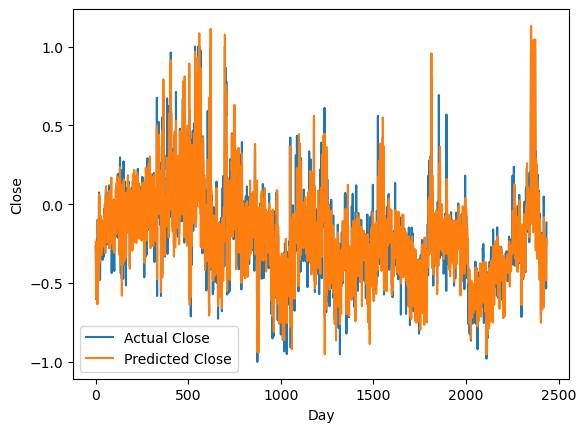

In [70]:
with torch.no_grad():
    predicted = model(X_train.to(device))

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [71]:
train_predictions = predicted.flatten()
print(train_predictions, predicted)

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)
print(dummies)

train_predictions = dc(dummies[:, 0])

tensor([-0.2395, -0.2493, -0.2938,  ..., -0.4840, -0.2161, -0.2548]) tensor([[-0.2395],
        [-0.2493],
        [-0.2938],
        ...,
        [-0.4840],
        [-0.2161],
        [-0.2548]])
[[41.28282876 52.63       52.63       ... 52.63       52.63
  52.63      ]
 [40.82175436 52.63       52.63       ... 52.63       52.63
  52.63      ]
 [38.71480048 52.63       52.63       ... 52.63       52.63
  52.63      ]
 ...
 [29.70076017 52.63       52.63       ... 52.63       52.63
  52.63      ]
 [42.39398358 52.63       52.63       ... 52.63       52.63
  52.63      ]
 [40.55862371 52.63       52.63       ... 52.63       52.63
  52.63      ]]


In [72]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([39.80000054, 38.53999933, 35.11000034, ..., 27.34000015,
       41.50999967, 47.10999996])

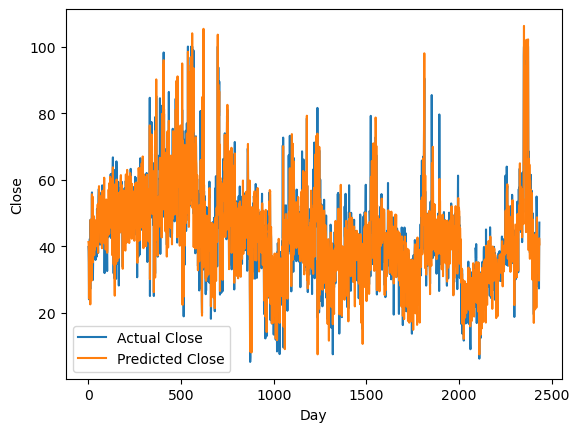

In [73]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [74]:
test_predictions = model(X_test.to(device)).detach().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])


In [75]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

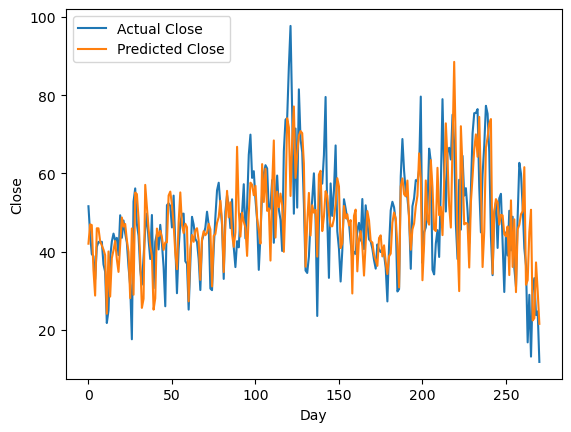

In [76]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [77]:
from sklearn.metrics import r2_score
r_squared = r2_score(new_y_train, train_predictions)
n = len(y_train)
k = X_train.shape[1]
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
print(f'R-squared: {r_squared:.3f}')
print(f'Adjusted R-squared: {adjusted_r_squared:.3f}')

mse = mean_squared_error(new_y_train, train_predictions)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

R-squared: 0.880
Adjusted R-squared: 0.879
RMSE: 4.827900869298927


In [78]:
data2 = data
data2.loc[2721:3086,'Average Cost'] = 0
df = dc(data2)
lookback = 15
df.set_index('Date', inplace=True)
for i in range(1, lookback + 1):
    df[f'Average Cost (t-{i})'] = df['Average Cost'].shift(i)


df[2721:]

,Average Cost,Average Cost (t-1),Average Cost (t-2),Average Cost (t-3),Average Cost (t-4),Average Cost (t-5),Average Cost (t-6),Average Cost (t-7),Average Cost (t-8),Average Cost (t-9),Average Cost (t-10),Average Cost (t-11),Average Cost (t-12),Average Cost (t-13),Average Cost (t-14),Average Cost (t-15)
Date,,,,,,,,,,,,,,,,


In [79]:
for i in range(2721, 3086):
    np_df = df.to_numpy()
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(-1,1))
    np_df = scaler.fit_transform(np_df)

    X = np_df[:, 1:]
    y = np_df[:, 0]
    X = dc(np.flip(X, axis=1))

    X_test = X[i]
    X_test = X_test.reshape((-1,lookback,1))
    X_test = torch.tensor(X_test).float()

    test_predictions = model(X_test.to(device)).detach().numpy().flatten()
    dummies = np.zeros((X_test.shape[0], lookback+1))
    dummies[:, 0] = test_predictions
    dummies = scaler.inverse_transform(dummies)

    test_predictions = dc(dummies[:, 0])
    
    data2.loc[i,'Average Cost'] = round(test_predictions[0], 1)
    df = dc(data2)
    lookback = 15
    df.set_index('Date', inplace=True)

    for j in range(1, lookback+1):
        df[f'Average Cost (t-{j})'] = df['Average Cost'].shift(j)

df[2721:]


IndexError: index 2721 is out of bounds for axis 0 with size 2721

In [ ]:
print(data2[2721:])
data2[2721:].to_csv('Result.csv', index=False)